# Seaborn — Beginner-to-Pro 🎯

**Goal.** A practical, opinionated reference you can drop into real EDA: we go from **beginner basics** → **intermediate customization** → **advanced patterns**, Short cells, clear plots, minimal ceremony.

**Datasets used:** `tips`, `penguins`, `flights`, `iris`, `titanic` (all built-in in Seaborn).


## 1) Setup & Theme

A theme helper function to quickly switch context/style. Set a random seed, widen the display, and load the built-in datasets.


In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# One-liner to flip contexts fast
def use_theme(context="notebook", style="whitegrid", palette="deep", figsize=(8,5)):
    sns.set_theme(context=context, style=style)
    sns.set_palette(palette)
    plt.rcParams["figure.figsize"] = figsize
    plt.rcParams["savefig.dpi"] = 180
    plt.rcParams["figure.dpi"] = 120

def quick_overview(df, topn=12):
    info = pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "n_unique": df.nunique(),
        "n_missing": df.isna().sum(),
        "missing_%": (df.isna().mean()*100).round(1)
    }).sort_values("missing_%", ascending=False)
    display(info.head(topn))
    display(df.describe(include="all").T.head(topn))

use_theme()
np.random.seed(42)
pd.set_option("display.max_colwidth", 120)

# Load datasets (built-in)
tips = sns.load_dataset("tips")
penguins = sns.load_dataset("penguins")
flights = sns.load_dataset("flights")
iris = sns.load_dataset("iris")
titanic = sns.load_dataset("titanic")

# quick peek
quick_overview(tips, topn=8)
tips.head()


,dtype,n_unique,n_missing,missing_%
total_bill,float64,229,0,0.0
tip,float64,123,0,0.0
sex,category,2,0,0.0
smoker,category,2,0,0.0
day,category,4,0,0.0
time,category,2,0,0.0
size,int64,6,0,0.0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
total_bill,244.0,NaN,NaN,NaN,19.785943,8.902412,3.07,13.3475,17.795,24.1275,50.81
tip,244.0,NaN,NaN,NaN,2.998279,1.383638,1.0,2.0,2.9,3.5625,10.0
sex,244,2,Male,157,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smoker,244,2,No,151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,244,4,Sat,87,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time,244,2,Dinner,176,NaN,NaN,NaN,NaN,NaN,NaN,NaN
size,244.0,NaN,NaN,NaN,2.569672,0.9511,1.0,2.0,2.0,3.0,6.0


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


## 2) Beginner Plots

I start with simple, trustworthy views and only add complexity if the plot earns its place.


### 2.1 Histogram + KDE

Histograms give the first shape; KDE (smoothed density) is nice *when* the sample is reasonably large.


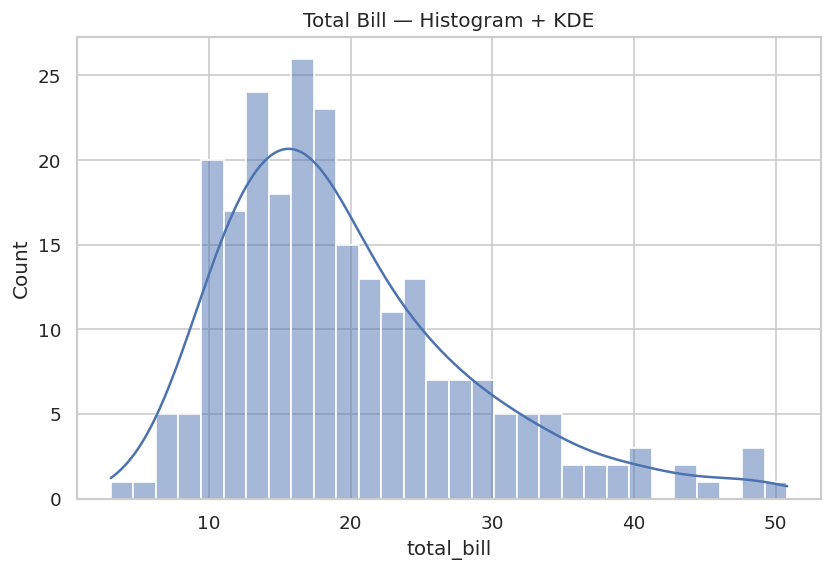

In [2]:
ax = sns.histplot(tips, x="total_bill", kde=True, bins=30)
ax.set_title("Total Bill — Histogram + KDE")
plt.show()


**Log-scale as a second lens** for heavy tails—don’t replace the linear view; show both.


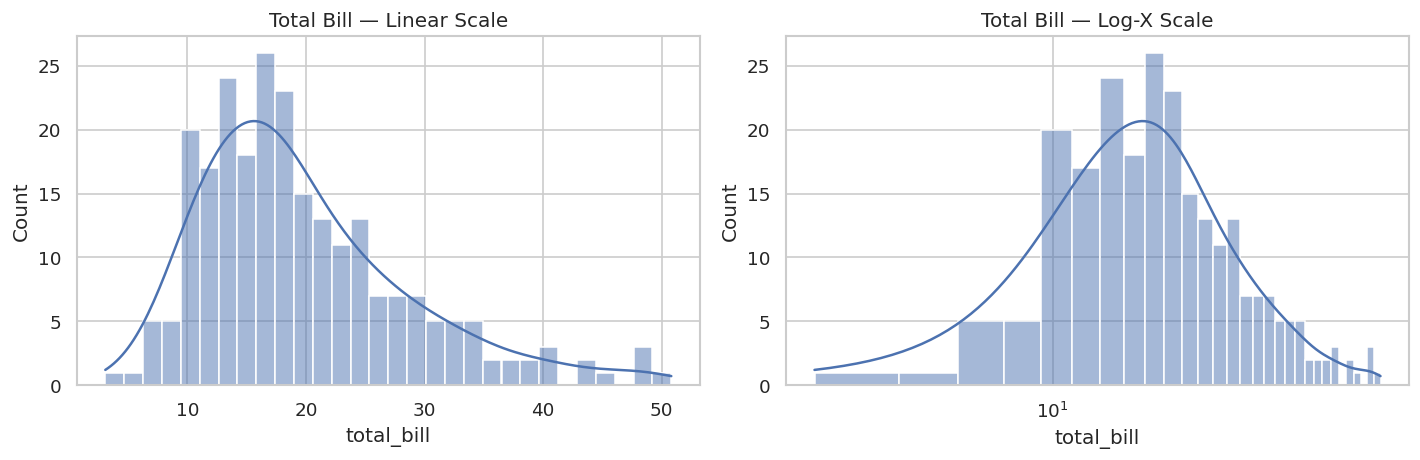

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(tips, x="total_bill", kde=True, bins=30, ax=axes[0])
axes[0].set_title("Total Bill — Linear Scale")

sns.histplot(tips, x="total_bill", kde=True, bins=30, ax=axes[1])
axes[1].set_xscale("log")
axes[1].set_title("Total Bill — Log-X Scale")
fig.tight_layout()
plt.show()


### 2.2 Countplot (categorical)

A quick alarm for class imbalance or rare categories that might need merging. Sort for faster reading; add labels for clarity.


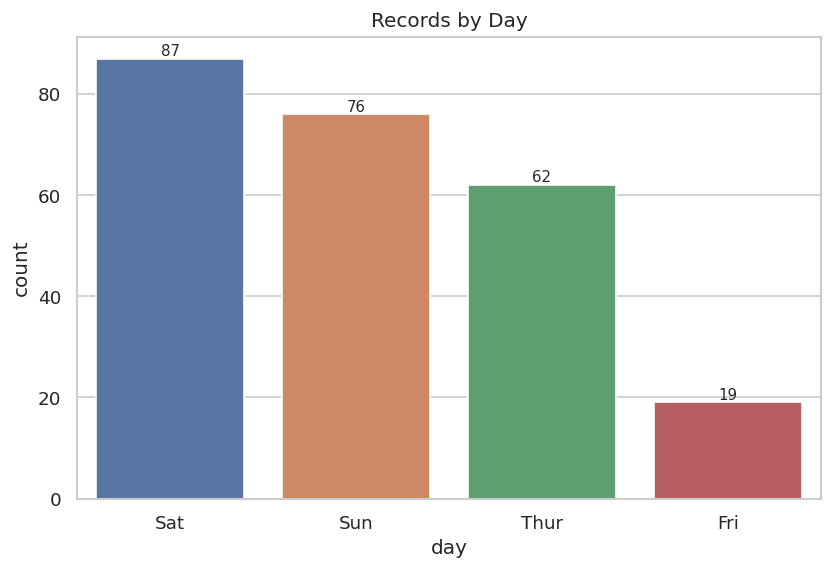

In [4]:
ax = sns.countplot(data=tips, x="day", order=tips["day"].value_counts().index)
ax.set_title("Records by Day")

# Simple labels on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', 
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9)
plt.show()


### 2.3 Barplot vs Pointplot (mean vs median)

Means get distorted by skew; medians stay steadier and often tell a clearer story.


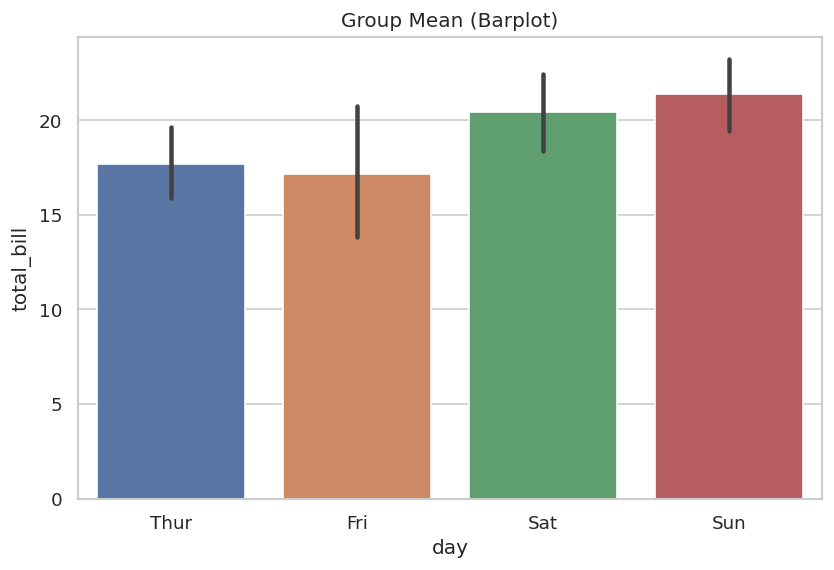

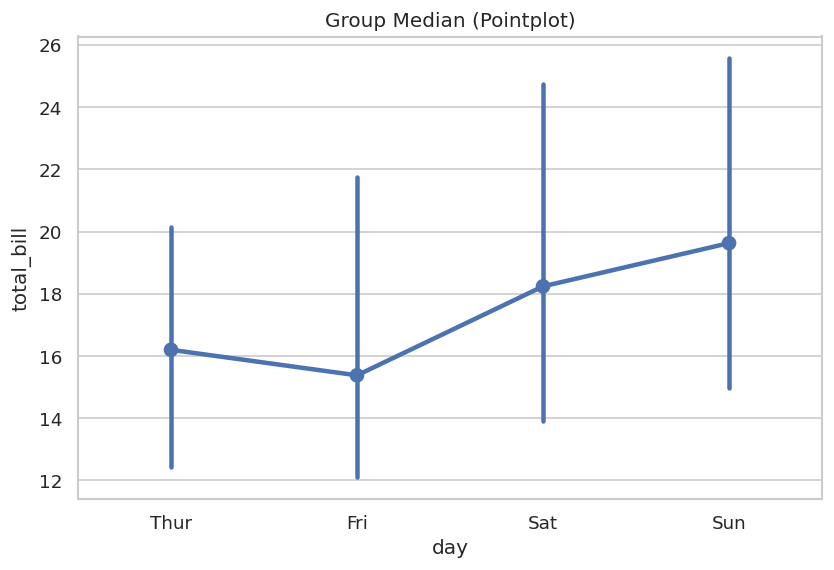

In [5]:
# A pointplot that estimates the median with a 50% interval 
def pointplot_median_with_interval(df, x, y, ax=None):
    import inspect
    sig = inspect.signature(sns.pointplot)
    kwargs = {}
    if "errorbar" in sig.parameters:      # seaborn >= 0.12
        kwargs["errorbar"] = ("pi", 50)   # percentile interval
    else:                                  # older seaborn
        kwargs["ci"] = 50
    return sns.pointplot(data=df, x=x, y=y, estimator=np.median, ax=ax, **kwargs)

fig, ax = plt.subplots()
sns.barplot(data=tips, x="day", y="total_bill", ax=ax)
ax.set_title("Group Mean (Barplot)")
plt.show()

fig, ax = plt.subplots()
pointplot_median_with_interval(tips, x="day", y="total_bill", ax=ax)
ax.set_title("Group Median (Pointplot)")
plt.show()


### 2.4 Scatter & Line

Use scatter for association/spread/outliers. Use line when **x is ordered or temporal**.


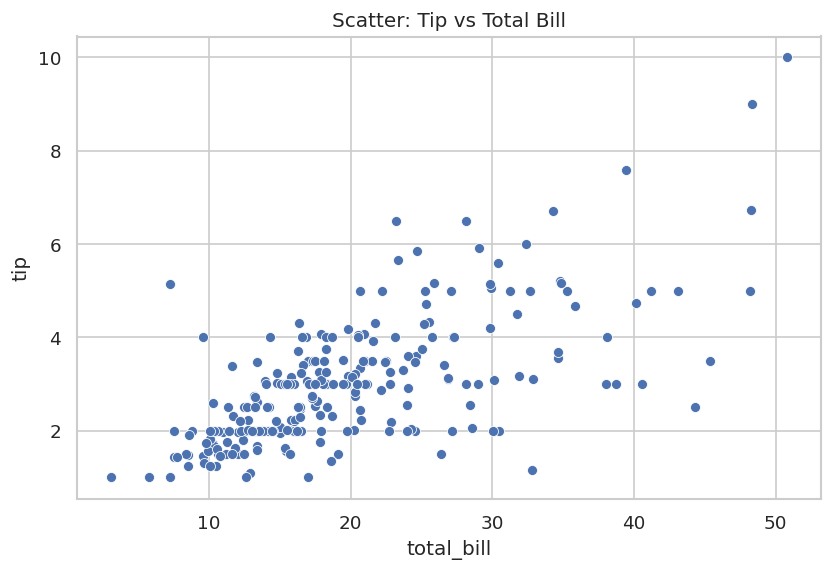

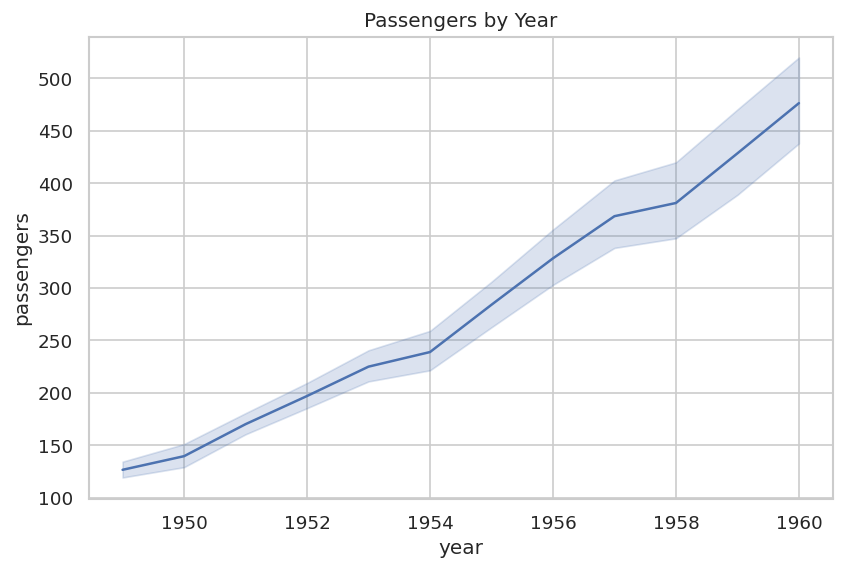

In [6]:
sns.scatterplot(data=tips, x="total_bill", y="tip")
plt.title("Scatter: Tip vs Total Bill")
plt.show()

sns.lineplot(data=flights, x="year", y="passengers")
plt.title("Passengers by Year")
plt.show()


## 3) Intermediate Customization

When a single plot starts carrying too much meaning, I either facet or reduce encodings.


### 3.1 Hue, Style, Size

Two encodings are usually my limit before readability drops.


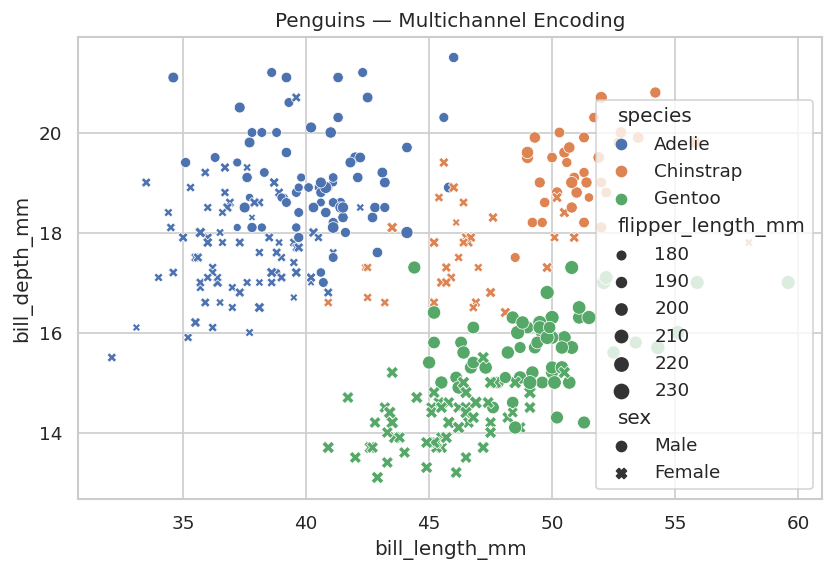

In [7]:
sns.scatterplot(
    data=penguins,
    x="bill_length_mm", y="bill_depth_mm",
    hue="species", style="sex", size="flipper_length_mm"
)
plt.title("Penguins — Multichannel Encoding")
plt.show()


### 3.2 FacetGrid & catplot

Facets turn one busy figure into a set of comparable mini-plots.


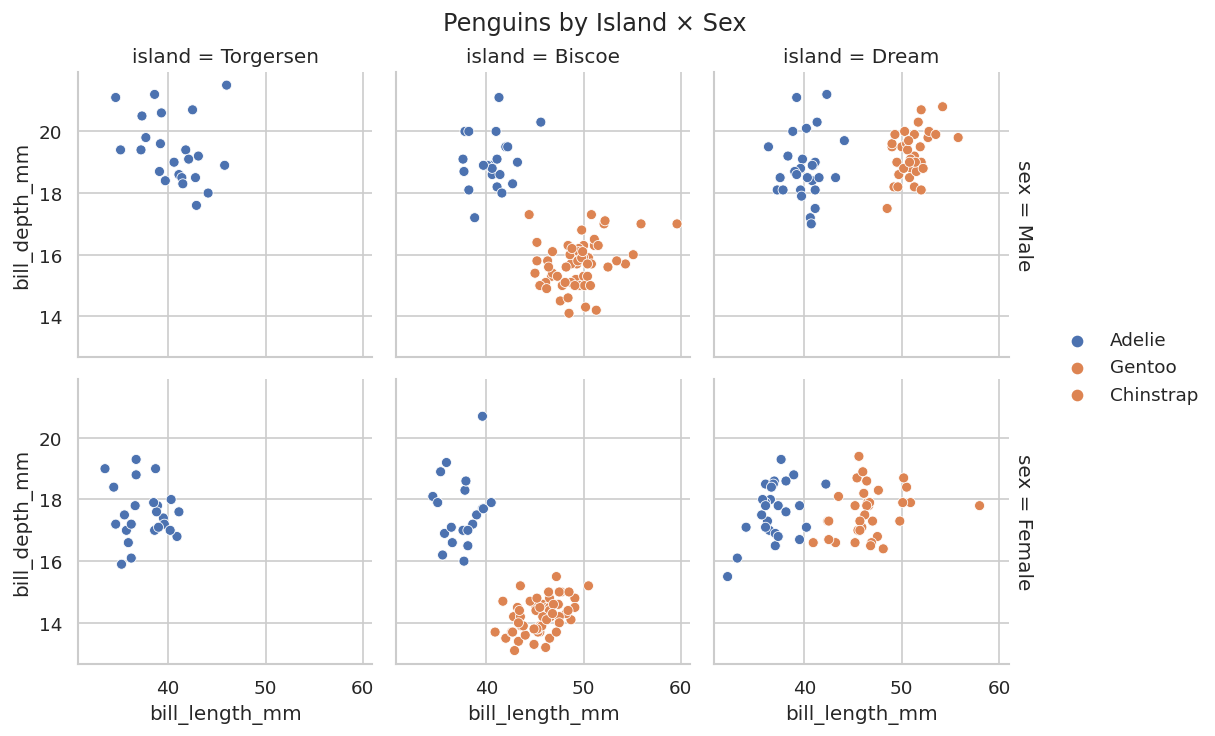

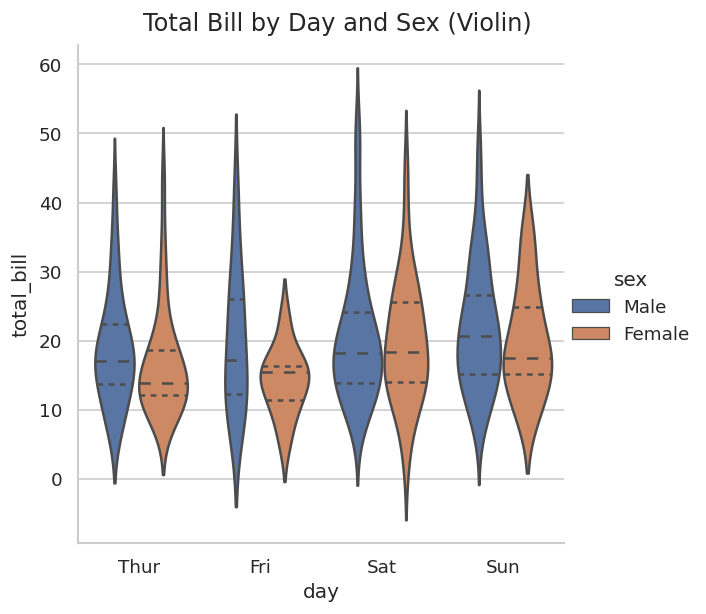

In [8]:
g = sns.FacetGrid(data=penguins, col="island", row="sex", margin_titles=True)
g.map_dataframe(sns.scatterplot, x="bill_length_mm", y="bill_depth_mm", hue="species")
g.add_legend()
g.fig.suptitle("Penguins by Island × Sex", y=1.02)
plt.show()

g = sns.catplot(data=tips, x="day", y="total_bill", hue="sex",
                kind="violin", dodge=True, inner="quartile")
g.fig.suptitle("Total Bill by Day and Sex (Violin)", y=1.02)
plt.show()


### 3.3 Palettes & Themes

A palette/context swap can save a cluttered plot. I default to `colorblind` or `deep`.


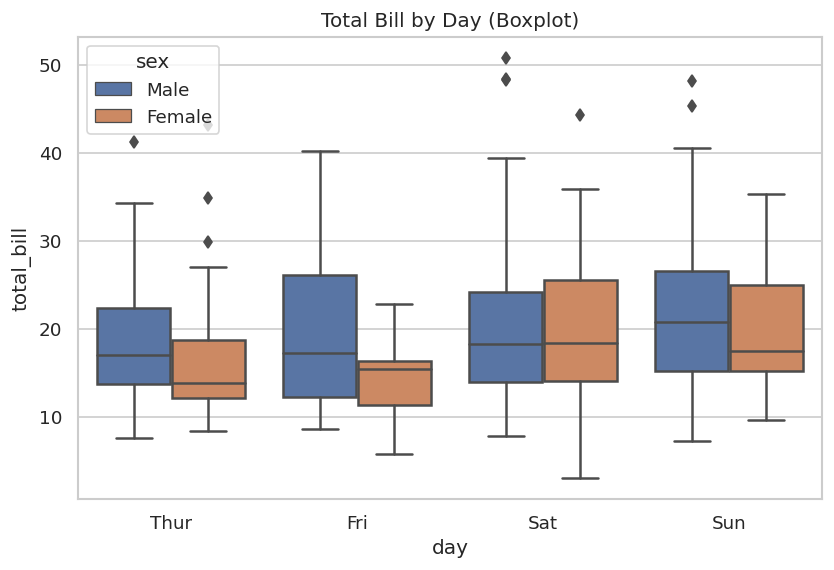

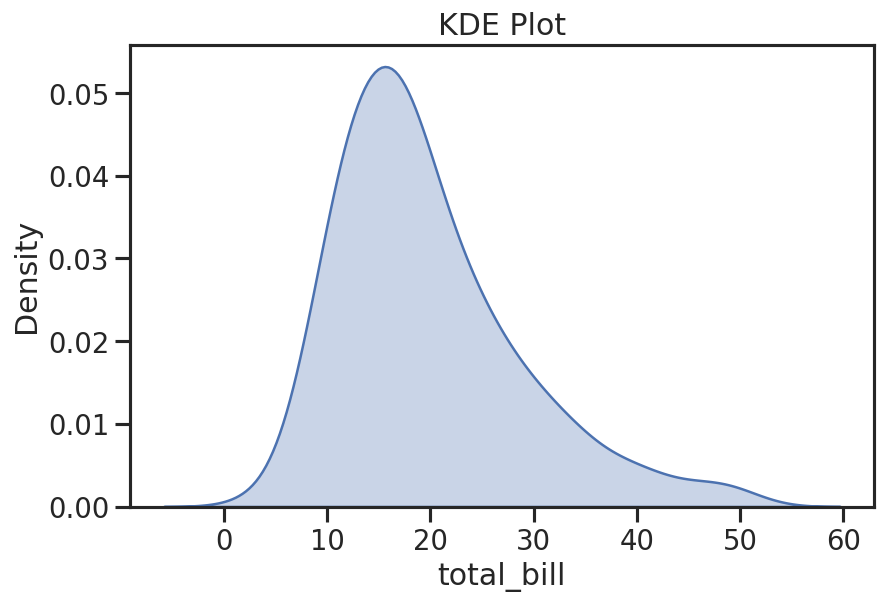

In [9]:
sns.set_palette("deep")
ax = sns.boxplot(data=tips, x="day", y="total_bill", hue="sex")
ax.set_title("Total Bill by Day (Boxplot)")
plt.show()

sns.set_theme(context="talk", style="ticks")
ax = sns.kdeplot(data=tips, x="total_bill", fill=True, alpha=0.3)
ax.set_title("KDE Plot")
plt.show()

use_theme()  # reset back to default


### 3.4 Axes handling & Matplotlib interop

Keep the `ax` handle—it's your remote control for titles/limits/formatters.


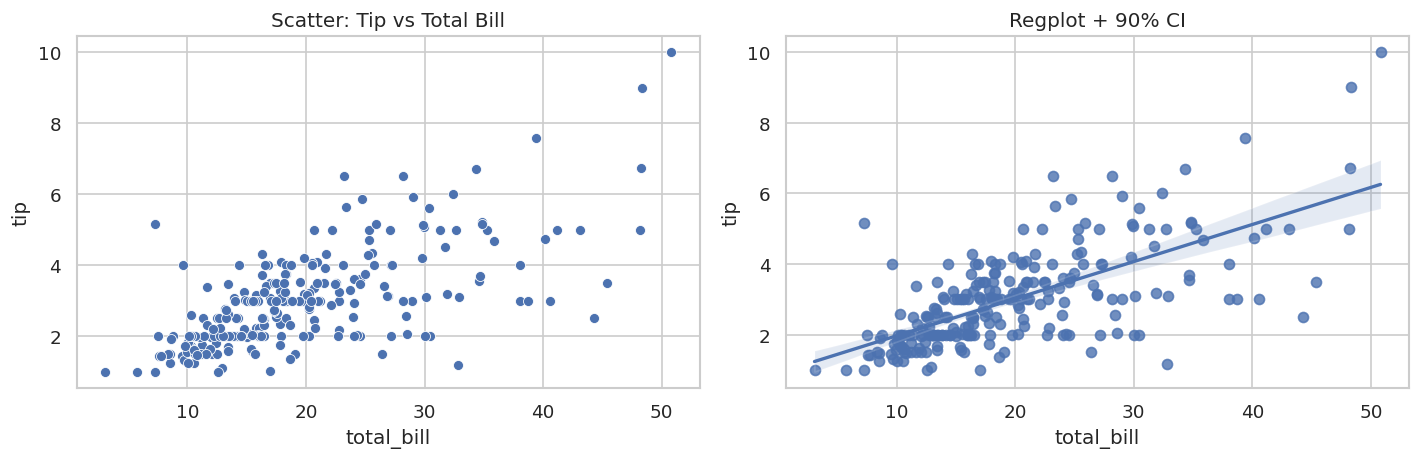

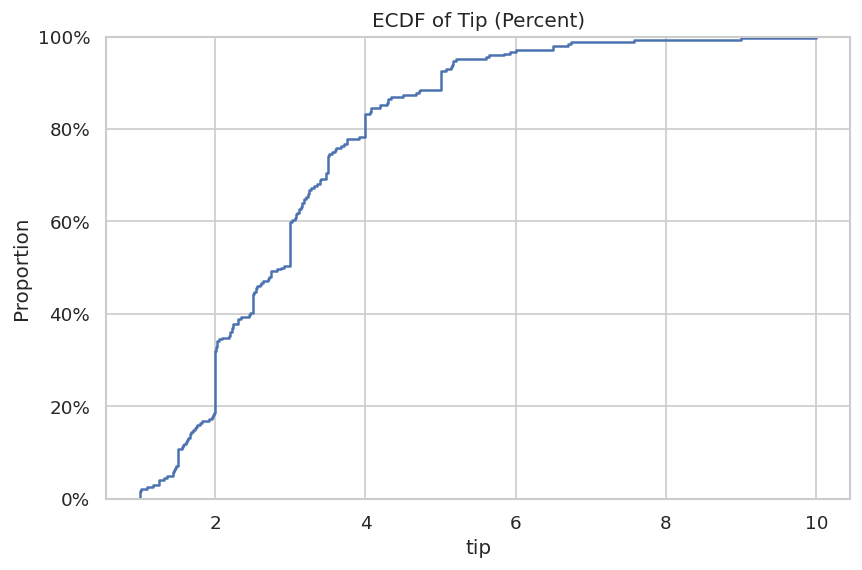

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(data=tips, x="total_bill", y="tip", ax=axes[0])
axes[0].set_title("Scatter: Tip vs Total Bill")

sns.regplot(data=tips, x="total_bill", y="tip", ax=axes[1], ci=90, line_kws={"linewidth": 2})
axes[1].set_title("Regplot + 90% CI")
fig.tight_layout()
plt.show()

from matplotlib.ticker import FuncFormatter
ax = sns.ecdfplot(data=tips, x="tip")
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _ : f"{v:.0%}"))
ax.set_title("ECDF of Tip (Percent)")
plt.show()


## 4) Advanced Patterns

These are powerful; use with care on wide/large data (sampling helps).


### 4.1 Pairplot & Jointplot

`corner=True` reduces clutter; `jointplot(kind="hex")` handles dense clouds nicely.


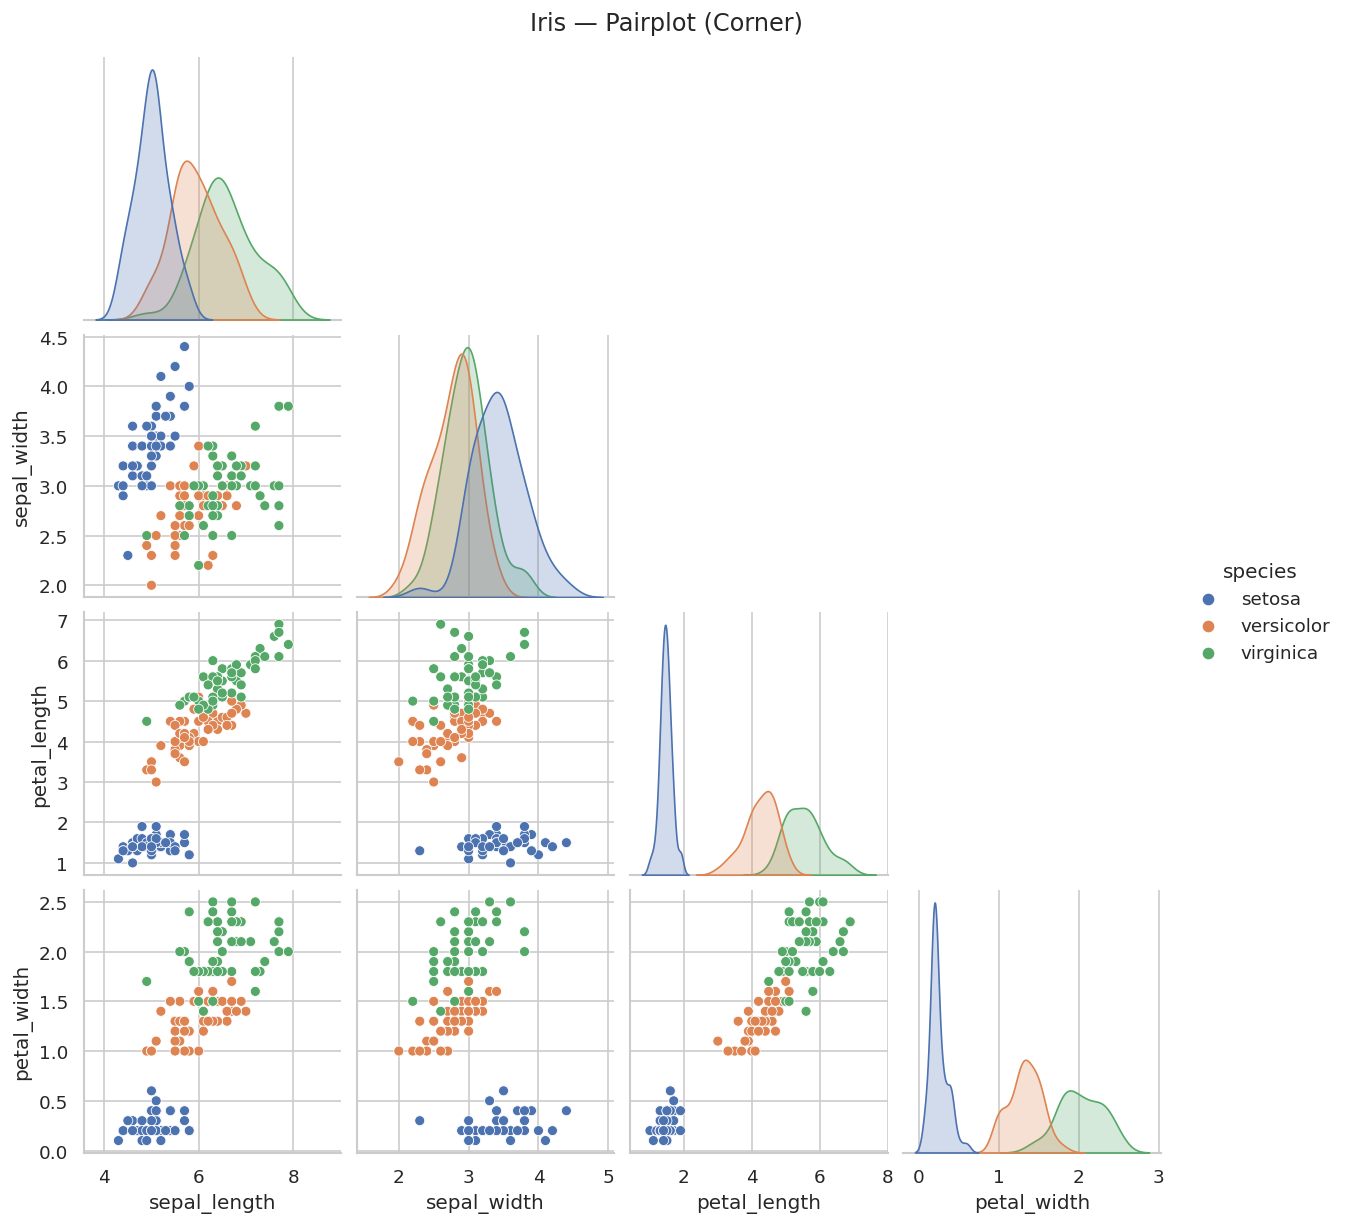

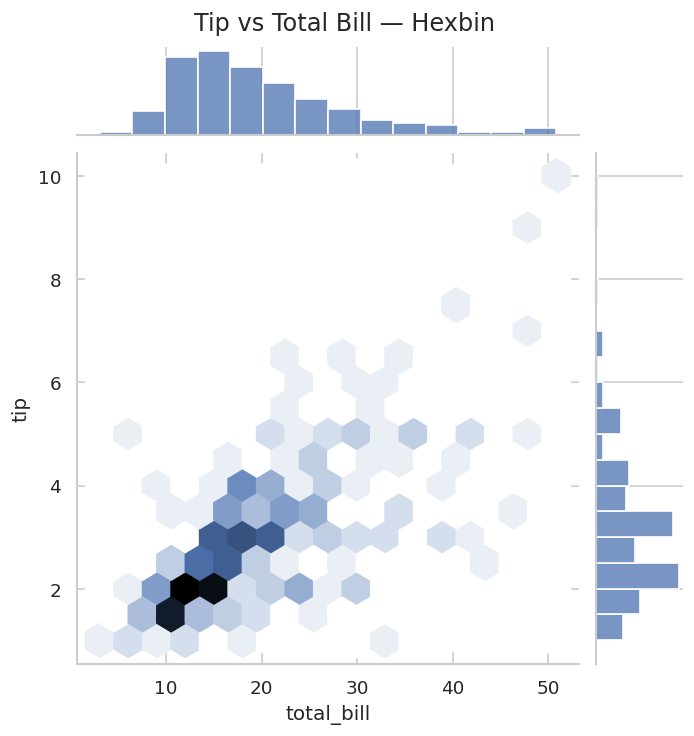

In [11]:
g = sns.pairplot(iris, hue="species", corner=True, diag_kind="kde")
g.fig.suptitle("Iris — Pairplot (Corner)", y=1.02)
plt.show()

g = sns.jointplot(data=tips, x="total_bill", y="tip", kind="hex")
g.fig.suptitle("Tip vs Total Bill — Hexbin", y=1.02)
plt.show()


### 4.2 Regression helpers (`regplot` / `lmplot`)

Trend ≠ causation — always scan residual patterns and non-linearity.


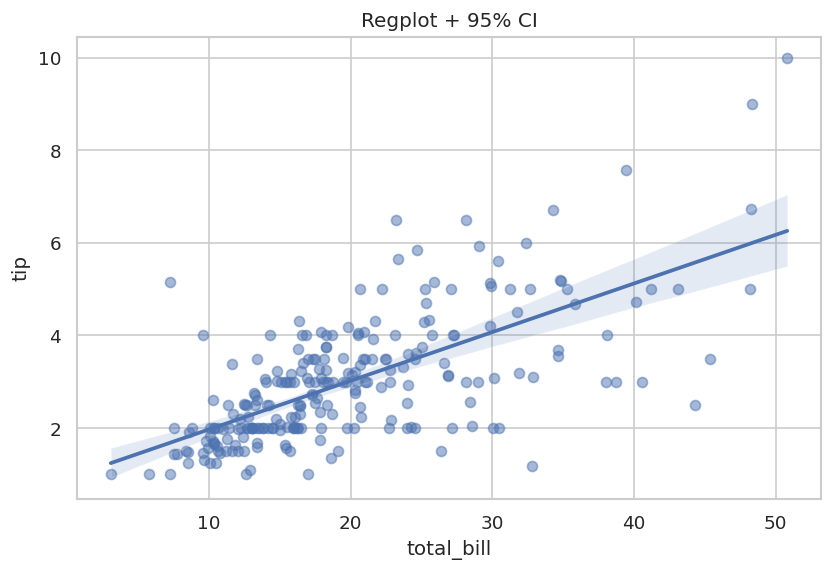

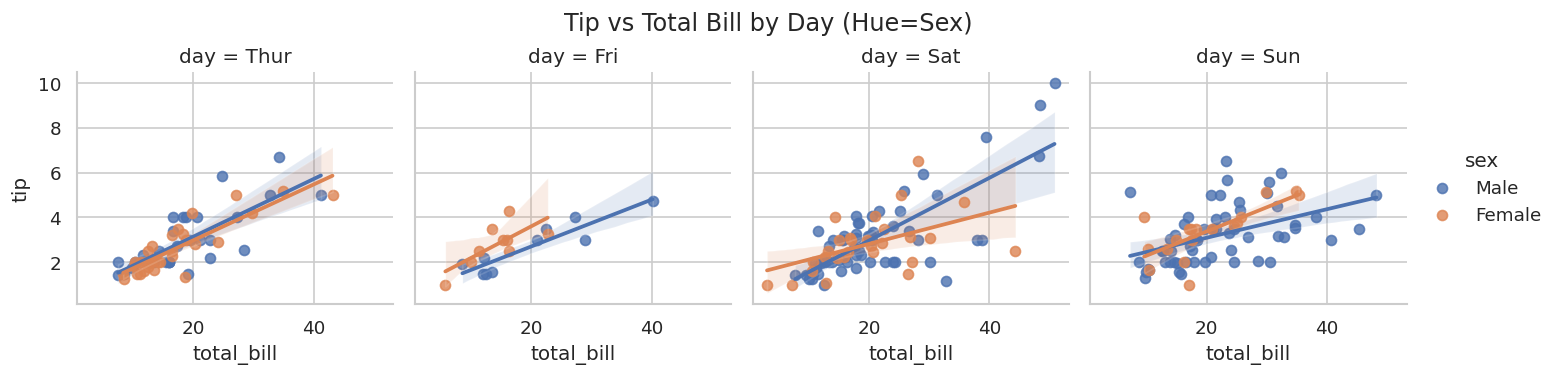

In [12]:
ax = sns.regplot(data=tips, x="total_bill", y="tip", ci=95, scatter_kws={"alpha":0.5})
ax.set_title("Regplot + 95% CI")
plt.show()

g = sns.lmplot(data=tips, x="total_bill", y="tip", hue="sex", col="day", height=3, aspect=1)
g.fig.suptitle("Tip vs Total Bill by Day (Hue=Sex)", y=1.04)
plt.show()


### 4.3 Distributions: ECDF

Bin-free, monotone, surprisingly informative for small samples.


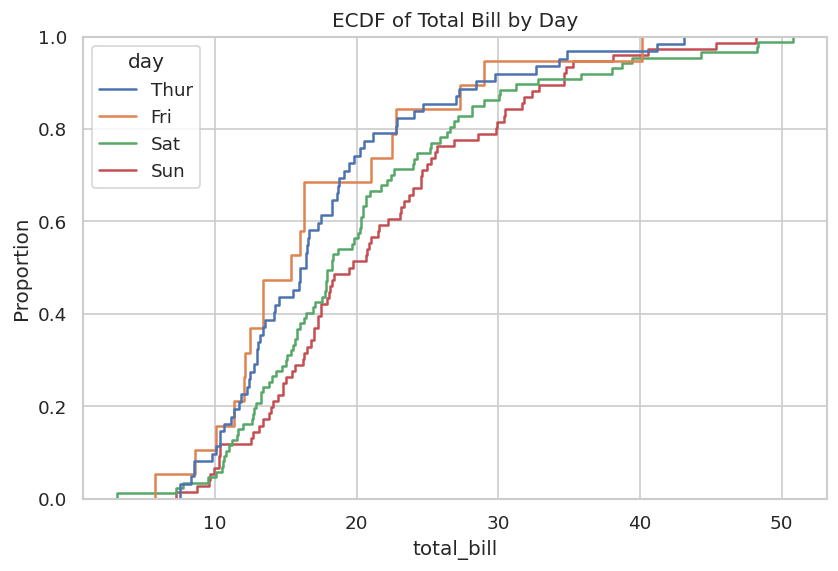

In [13]:
ax = sns.ecdfplot(data=tips, x="total_bill", hue="day")
ax.set_title("ECDF of Total Bill by Day")
plt.show()


### 4.4 Facet tricks

Give the plot a job: reference lines, thresholds, or targets unify interpretation across facets.


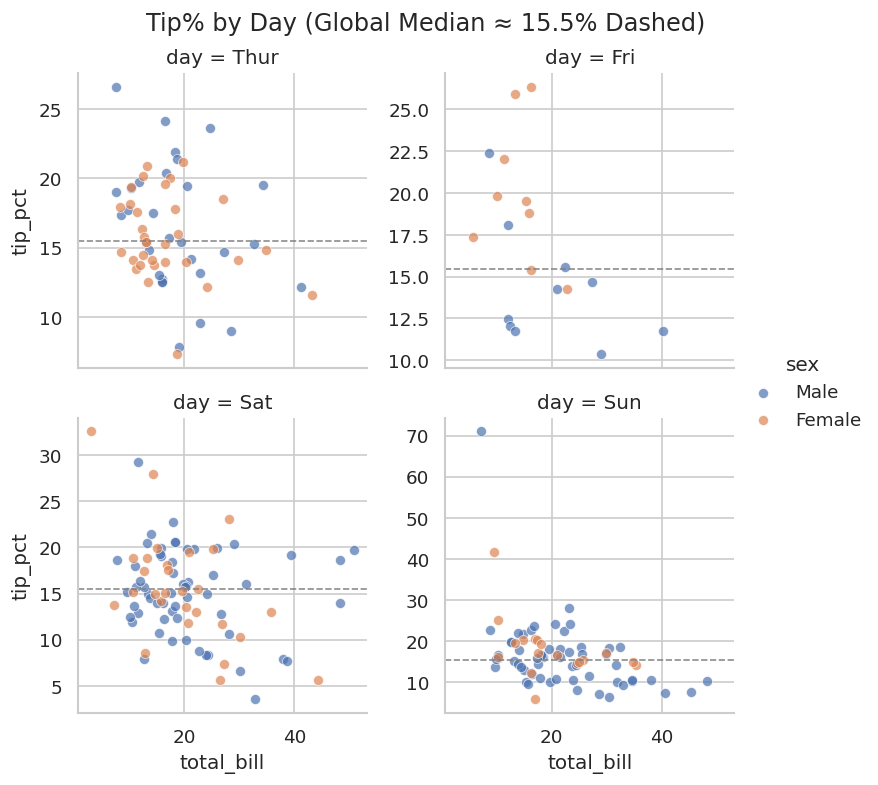

In [14]:
def add_zero_line(**kwargs):
    ax = plt.gca()
    ax.axhline(0, ls="--", lw=1, alpha=0.6, color="gray")

tips2 = tips.assign(tip_pct=lambda d: 100 * d["tip"]/d["total_bill"])
global_med = tips2["tip_pct"].median()

g = sns.FacetGrid(tips2, col="day", hue="sex", col_wrap=2, height=3.2, sharey=False)
g.map_dataframe(sns.scatterplot, x="total_bill", y="tip_pct", alpha=0.7)
g.map_dataframe(lambda data, color, **k: plt.axhline(global_med, ls="--", lw=1, alpha=0.6, color="gray"))
g.add_legend()
g.fig.suptitle(f"Tip% by Day (Global Median ≈ {global_med:.1f}% Dashed)", y=1.02)
plt.show()


**Dense cloud?** Try hexbin for binned density instead of raw scatter transparency.


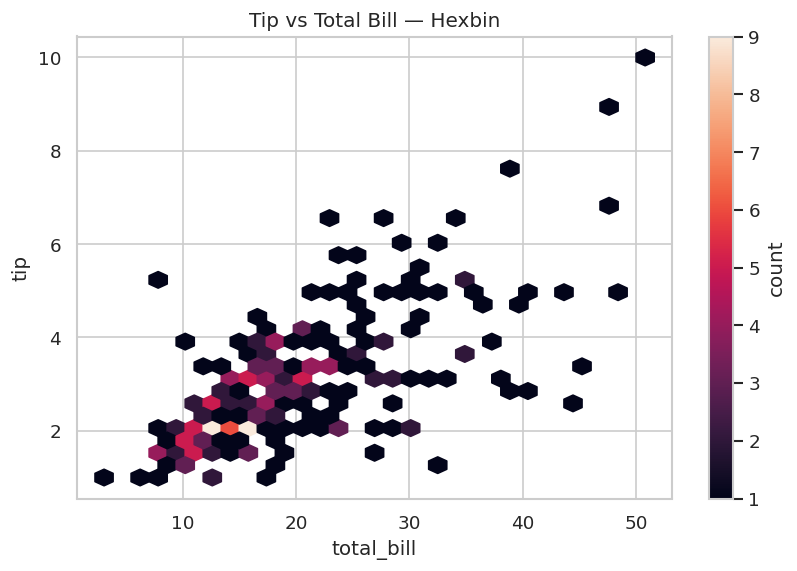

In [15]:
with plt.rc_context({"figure.figsize": (8,5)}):
    plt.hexbin(tips["total_bill"], tips["tip"], gridsize=30, mincnt=1)
    plt.title("Tip vs Total Bill — Hexbin")
    plt.xlabel("total_bill"); plt.ylabel("tip"); plt.colorbar(label="count")
    plt.show()


**Small-multiples for seasonality** instead of a single thick line.


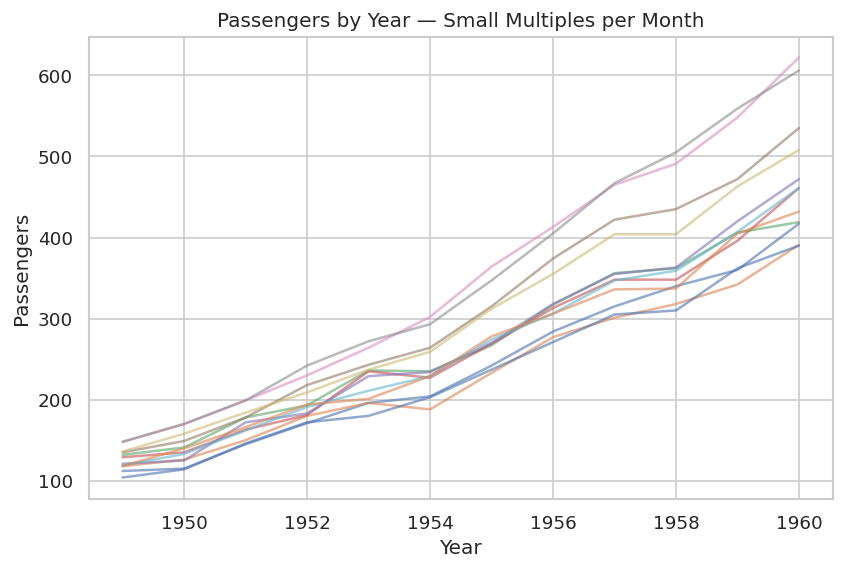

In [16]:
flw = flights.pivot_table(index="year", columns="month", values="passengers")
flw.plot(legend=False, alpha=0.6)
plt.title("Passengers by Year — Small Multiples per Month")
plt.xlabel("Year"); plt.ylabel("Passengers")
plt.show()


**Correlation heatmap** on numeric-only columns, masking the upper triangle to reduce clutter.


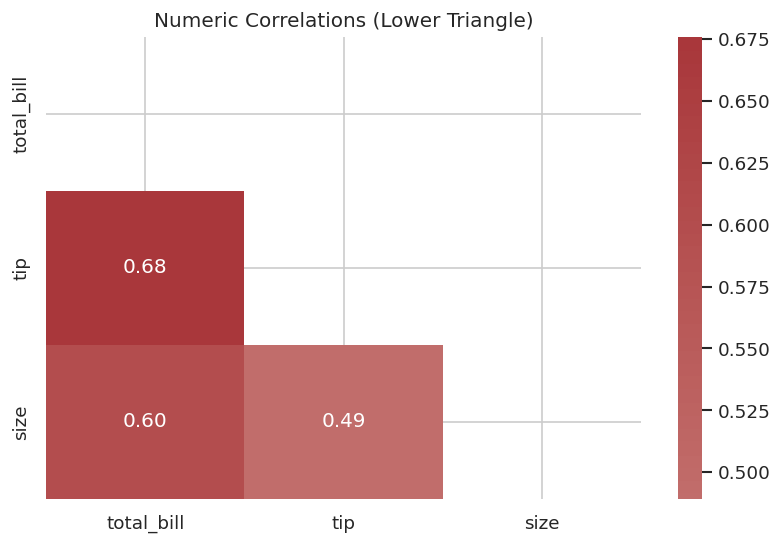

In [17]:
num = tips.select_dtypes(include=[np.number])
corr = num.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Numeric Correlations (Lower Triangle)")
plt.show()


### Quick Gallery (one-shot overview)

A fast visual sampler—handy on Kaggle to show variety at a glance.


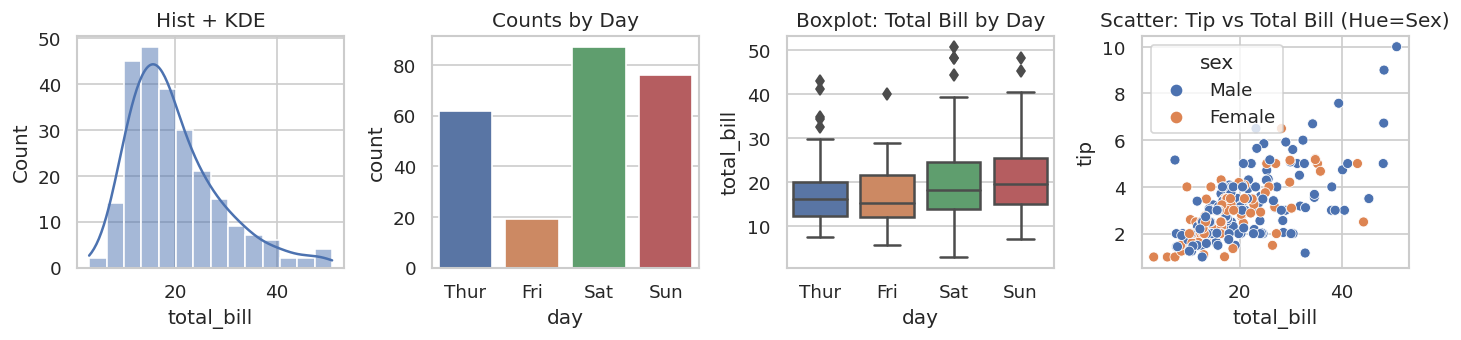

In [18]:
use_theme(figsize=(12,3))
fig, axs = plt.subplots(1,4)
sns.histplot(data=tips, x="total_bill", kde=True, ax=axs[0]); axs[0].set_title("Hist + KDE")
sns.countplot(data=tips, x="day", ax=axs[1]); axs[1].set_title("Counts by Day")
sns.boxplot(data=tips, x="day", y="total_bill", ax=axs[2]); axs[2].set_title("Boxplot: Total Bill by Day")
sns.scatterplot(data=tips, x="total_bill", y="tip", hue="sex", ax=axs[3]); axs[3].set_title("Scatter: Tip vs Total Bill (Hue=Sex)")
fig.tight_layout(); plt.show()
use_theme()  # reset


## 5) EDA Mini‑Pipeline 

Compact flow I reuse: quick overview → missingness → simple target relationships.  
Example target: `titanic.survived` (this is *EDA*, not modeling best practice).


Shape: (891, 15)


,dtype,n_unique,n_missing,missing_%
deck,category,7,688,77.2
age,float64,88,177,19.9
embarked,object,3,2,0.2
embark_town,object,3,2,0.2
survived,int64,2,0,0.0
pclass,int64,3,0,0.0
sex,object,2,0,0.0
sibsp,int64,7,0,0.0
parch,int64,7,0,0.0
fare,float64,248,0,0.0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
sibsp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292
embarked,889,3,S,644,NaN,NaN,NaN,NaN,NaN,NaN,NaN
class,891,3,Third,491,NaN,NaN,NaN,NaN,NaN,NaN,NaN
who,891,3,man,537,NaN,NaN,NaN,NaN,NaN,NaN,NaN


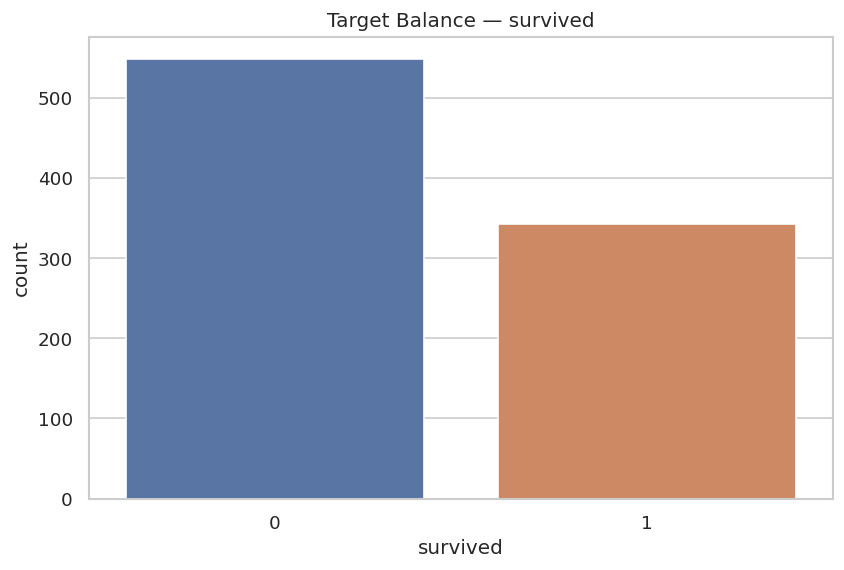

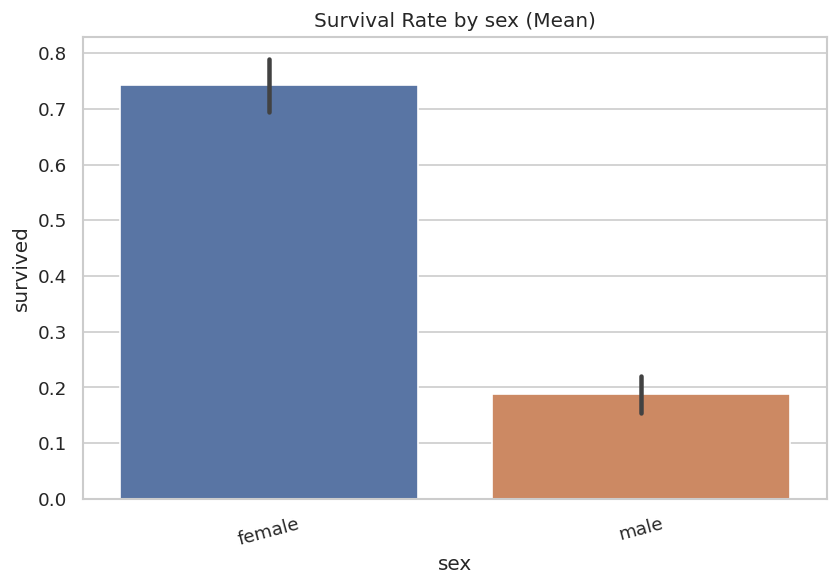

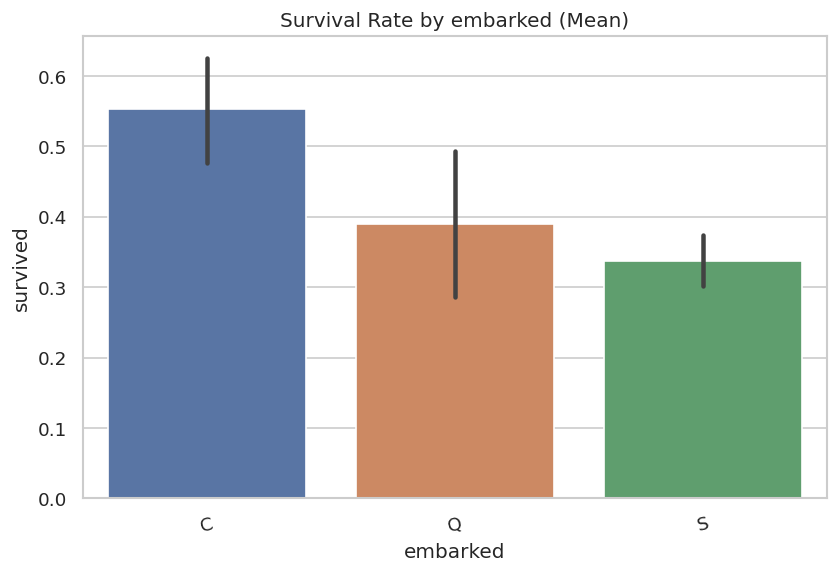

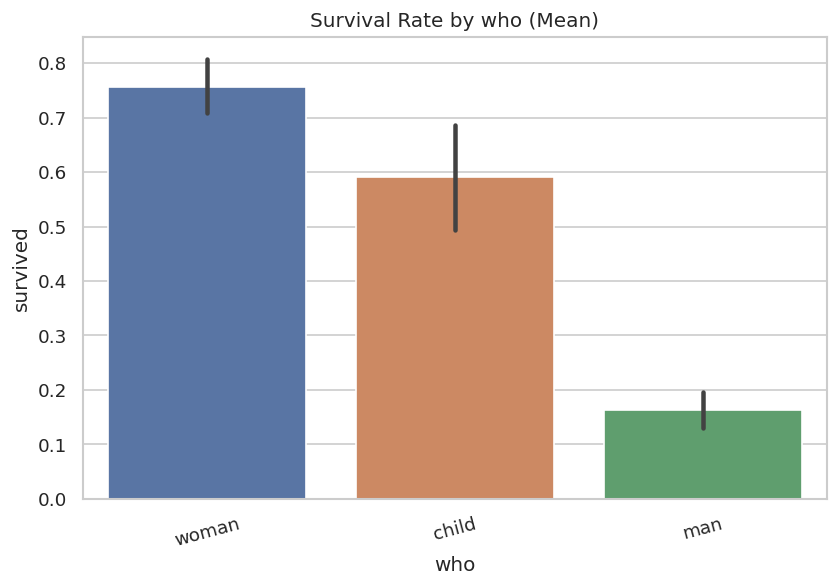

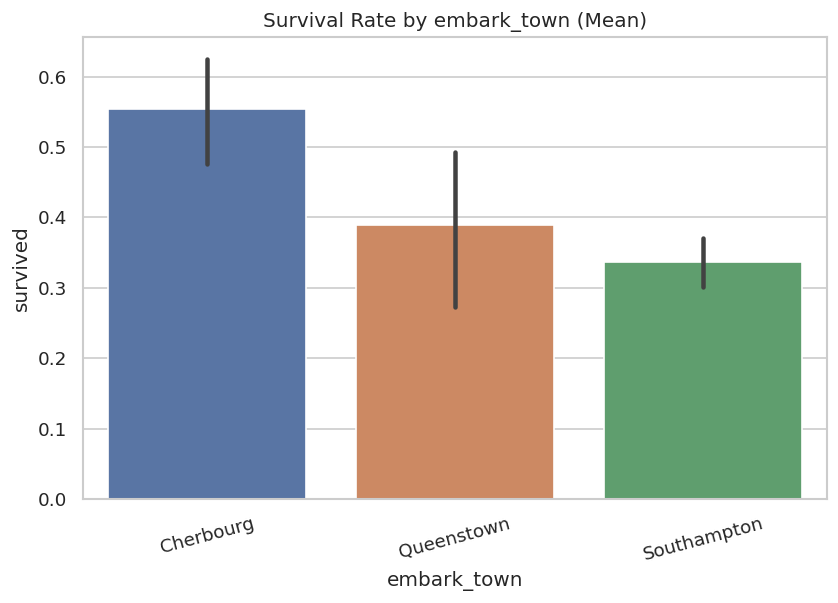

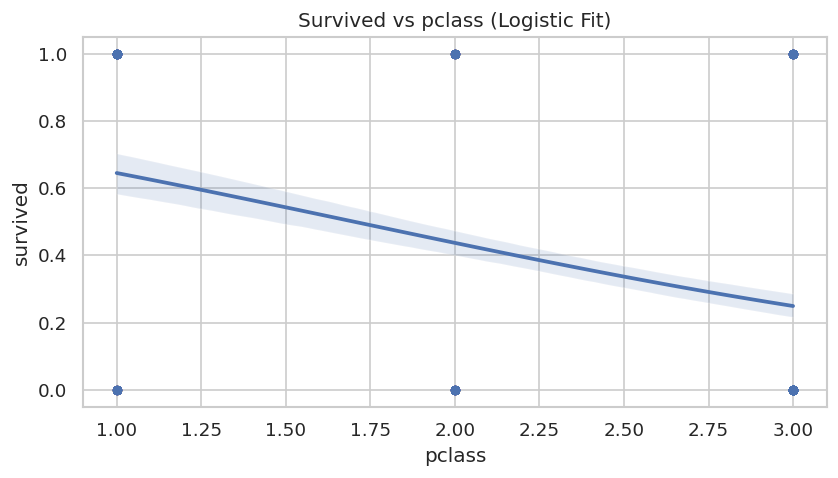

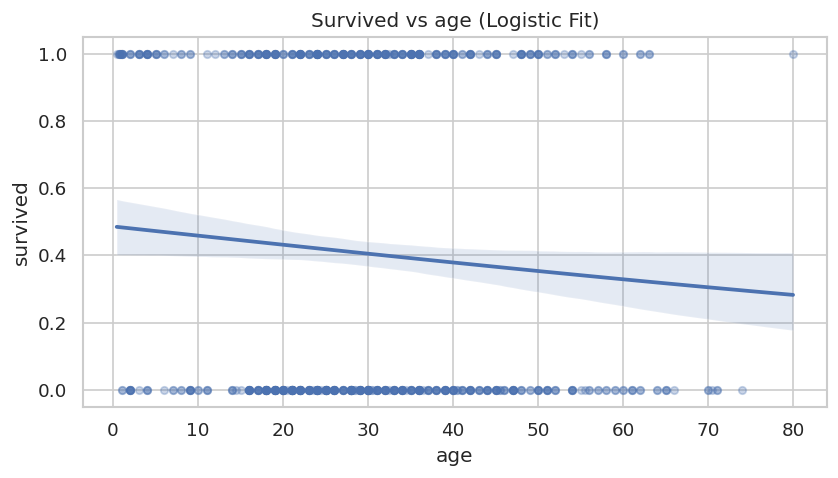

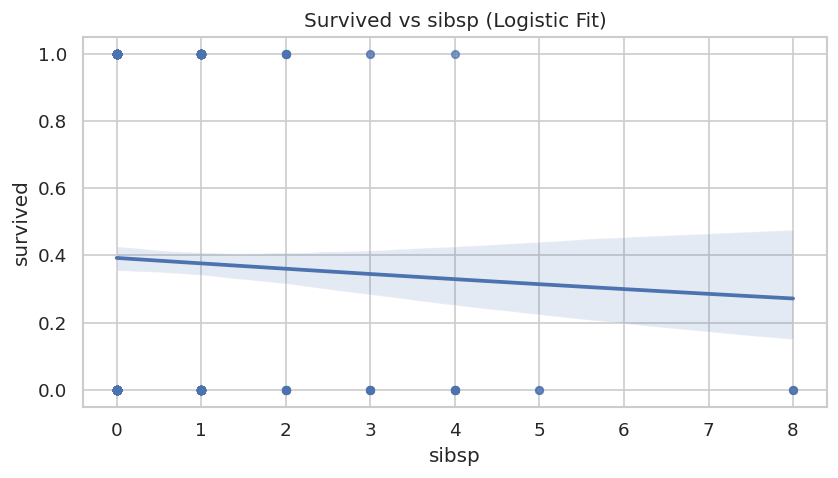

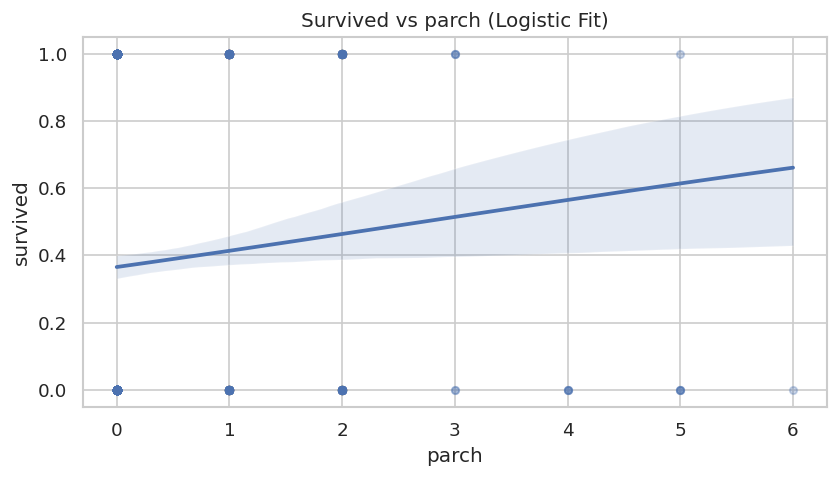

In [19]:
df = titanic.copy()
target = "survived"

print("Shape:", df.shape)
quick_overview(df, topn=12)

# Simple imputations 
df["age_f"] = df["age"].fillna(df["age"].median())
df["embarked_f"] = df["embarked"].fillna(df["embarked"].mode()[0])

# Target balance
ax = sns.countplot(data=df, x=target)
ax.set_title(f"Target Balance — {target}")
plt.show()

# Top categorical relations (mean target) — capped at 6 uniques
cat_cols = [c for c in df.columns if df[c].dtype == 'object' and df[c].nunique() <= 6]
for c in cat_cols[:4]:
    order = df.groupby(c)[target].mean().sort_values(ascending=False).index
    ax = sns.barplot(data=df, x=c, y=target, order=order)
    ax.set_title(f"Survival Rate by {c} (Mean)")
    plt.xticks(rotation=15)
    plt.show()

# Numeric vs target (logistic fit gives smoother trend for binary targets)
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != target]
for c in num_cols[:4]:
    fig, ax = plt.subplots(figsize=(8,4))
    
    # logistic=True needs statsmodels. If not installed, set logistic=False or run: pip install statsmodels
    sns.regplot(data=df, x=c, y=target, logistic=True, scatter_kws={"alpha":0.3, "s":20})
    ax.set_title(f"Survived vs {c} (Logistic Fit)")
    plt.show()


## 6) Best Practices & Pitfalls

- ECDF is robust for small samples (avoids bin lottery).  
- Don’t overload hue + style + size unless the story is strong; facet instead.  
- Always name your estimator (mean vs median).  
- Confidence intervals don’t measure effect size, they just show sampling uncertainty. 
- For dense scatter, use transparency (`alpha`), binning (`hex`), or sampling.  
- Log scales clarify heavy tails — but mislead if data contains zeros.  
- Sample or use `corner=True` on wide pairplots to avoid clutter.
- Many Seaborn plots accept log_scale=True (or set_xscale("log") in Matplotlib) — handy for heavy tails.


## 7) Cheat Sheet

| Goal | Function | Minimal Example | Common gotcha |
|---|---|---|---|
| Histogram + KDE | `histplot` | `sns.histplot(df, x="col", kde=True)` | Bad bin choice hides structure |
| Density | `kdeplot` | `sns.kdeplot(df, x="col", fill=True)` | Misleads on tiny `n` or multimodal |
| Counts | `countplot` | `sns.countplot(df, x="cat")` | Unsorted bars mask imbalance |
| Group Mean | `barplot` | `sns.barplot(df, x="cat", y="y")` | Mean on skewed data is fragile |
| Group Median | `pointplot` | `sns.pointplot(df, x="cat", y="y", estimator=np.median)` | State the estimator |
| Scatter | `scatterplot` | `sns.scatterplot(df, x="x", y="y")` | Overplotting → use alpha/bin/hex |
| Lines | `lineplot` | `sns.lineplot(df, x="t", y="y")` | Avoid when x is unordered |
| Box/Violin | `boxplot` / `violinplot` | `sns.violinplot(df, x="c", y="y")` | Noisy with small `n` |
| Pairwise | `pairplot` | `sns.pairplot(df, hue="label")` | Sample / use `corner=True` |
| Joint density | `jointplot` | `sns.jointplot(df, x="x", y="y", kind="hex")` | Dense scatter without binning |
| Regression | `regplot` / `lmplot` | `sns.lmplot(df, x="x", y="y", hue="h")` | Assuming linearity blindly |
| Faceting | `FacetGrid` / `catplot` | `sns.catplot(df, x="c", y="y", col="g")` | Too many panels/legends |
| Heatmap | `heatmap` | `sns.heatmap(df.corr())` | Correlation ≠ causation; numeric-only |
